# Auswertung des (zeitlichen) Nutzungsverhalten

In [1]:
import datetime as dt
import os
import re

import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages

### Import update_databases um die Datenbank zu aktualisieren wenn sie heute noch nicht aktualisiert wurde....
#from src import update_databases
from src.project_definitions import BUID, buid, WOHNUNGEN, ROOMS, dir_results
from src.utilities import truncate_colormap, export, din_a4,din_a4_landscape, eb_bbox, KOMPASS

import locale
locale.setlocale(locale.LC_ALL,'de_DE')

#### Messdaten Import
startdate = '2021-06-01'
print('Starte Import der Datensätze - das kann etwas dauern...')
from src.sensor_reader import IND
print('...Import beendet')

Starte Import der Datensätze - das kann etwas dauern...
...Import beendet


In [2]:
##### USER INPUTS #####
ex = False

## Auswertung Fensterkontakt, Bewegungsmelder und Stromverbrauch pro Wohneinheit
___
Mittelwerte über den Tagesverlauf, stündliche Auflösung

In [3]:
plt.style.use('./src/stylesheets/eb3.mplstyle')

MDs = {}
WINs = {}
ELs = {}
path = os.path.join(dir_results, 'Nutzungsverhalten')
if not os.path.exists(path): os.makedirs(path)


_wohnungen = ['S','N']
if not ex:
    bui = 'MW'
    buid = {bui : buid[bui]}
    _wohnungen = ['N', 'S']
    focus_month = dt.date(2022,2,1)

for bui, color in buid.items():    
    for app in _wohnungen:
        with PdfPages(os.path.join(path, f'{bui}_{app}_Vergleich_reed_md_el_monatlich.pdf')) as pdf:
            for name, group in IND[bui][app].groupby([IND[bui][app].index.year, IND[bui][app].index.month]):
                date = dt.date(name[0], name[1], 1)
                if not ex and date != focus_month:
                    continue
                else:
                    fig, axs = plt.subplots(7,1,figsize=din_a4)
                    fig.suptitle(f'{BUID[bui]} | {WOHNUNGEN[app]} | {date.strftime("%B %Y")}')

                    # Bewegunsmelder Wohnzimmer
                    ax = axs[0]
                    room = 'WZ'
                    dataset = (group[room].filter(like='_md').resample('H').max())
                    dataset = dataset.groupby(dataset.index.hour).mean()
                    MDs[(bui, app, room)] = dataset.mean(axis=1)

                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=[f'{KOMPASS[col.split("_")[0]]}fassade' for col in dataset.columns])
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.set_title(f'Bewegungsmelder Wohnzimmer')
                    ax.set_ylim(0,100)
                    ax.grid(axis="y", ls='dotted')
                    ax.grid(axis='x',which='both', linestyle='dotted')

                    # Fenster Wohnzimmer
                    ax = axs[4]
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').sum()
                    dataset = dataset.groupby(dataset.index.hour).mean()
                    labels=[]
                    for col in dataset.columns:
                        ori = KOMPASS[col.split('_')[0]]
                        size = re.search(r'\[(.*?)\]', col)[0]
                        labels.append(f"{ori} {size}")
                        WINs[(bui, app, room, col)] = dataset[col]

                    dataset.plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.set_title(f'Fenster Wohnzimmer')
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_ylim(0,60)
                    ax.grid(axis="y", ls='dotted')
                    ax.grid(axis='x',which='both', linestyle='dotted')

                    # Bewegunsmelder Flur
                    ax = axs[1]
                    room = 'F'
                    dataset = (group[room].filter(like='_md').resample('H').max())
                    dataset = dataset.groupby(dataset.index.hour).mean()
                    MDs[(bui, app, room)] = dataset.mean(axis=1)
                    dataset.mul(100).plot.bar(ax=ax,cmap = color)  
                    ax.legend(labels = [f'{KOMPASS[col.split("_")[0]]}fassade' for col in dataset.columns], loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())          
                    ax.set_title(f'Bewegungsmelder Flur')
                    ax.set_ylim(0,100)
                    ax.grid(axis="y", ls='dotted')
                    ax.grid(axis='x',which='both', linestyle='dotted')

                    #Fenster Flur
                    ax = axs[2]
                    room = 'F'
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean()
                    dataset = dataset.groupby(dataset.index.hour).mean()
                    labels = []
                    for col in dataset.columns:
                        ori = KOMPASS[col.split('_')[0]]
                        size = re.search(r'\[(.*?)\]', col)[0]
                        labels.append(f"{ori} {size}")
                        WINs[(bui, app, room, col)] = dataset[col]

                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_title(f'Fenster Flur')
                    ax.set_ylim(0,100)
                    ax.grid(axis="y", ls='dotted')
                    ax.grid(axis='x',which='both', linestyle='dotted')

                    #Fenster Küche
                    ax = axs[3]
                    room = 'K'
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean()
                    dataset = dataset.groupby(dataset.index.hour).mean()
                    labels=[]
                    for col in dataset.columns:
                        ori = KOMPASS[col.split('_')[0]]
                        size = re.search(r'\[(.*?)\]', col)[0]
                        labels.append(f"{ori} {size}")
                        WINs[(bui, app, room, col)] = dataset[col]

                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_title(f'Fenster Küche')
                    ax.set_ylim(0,100)
                    ax.grid(axis="y", ls='dotted')
                    ax.grid(axis='x',which='both', linestyle='dotted')

                    #Fenster Schlafzimmer
                    ax = axs[5]
                    room = 'SZ'
                    dataset = group[room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean()   
                    dataset = dataset.groupby(dataset.index.hour).mean()
                    labels = []
                    for col in dataset.columns:
                        ori = KOMPASS[col.split('_')[0]]
                        size = re.search(r'\[(.*?)\]', col)[0]
                        labels.append(f"{ori} {size}")
                        WINs[(bui, app, room, col)] = dataset[col]  
                    dataset.mul(100).plot.bar(ax=ax,cmap = color)
                    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False,labels=labels)
                    ax.set_title(f'Fenster Schlafzimmer')
                    ax.set_ylim(0,100)
                    ax.grid(axis="y", ls='dotted')
                    ax.grid(axis='x',which='both', linestyle='dotted')

                    #Stromzähler
                    ax = axs[6]
                    room = ''
                    dataset = group[room].filter(like='(W)').abs().sum(axis=1).resample('H').mean()
                    dataset = dataset.groupby(dataset.index.hour).mean()
                    ELs[(bui, app, room)] = dataset   
                    dataset.mul(100).plot.bar(ax=ax,cmap = color, alpha = 0.5)
                    ax.text(0.5,0.5,'Achtung!\nStrommessungen durch fehlerhaften Messaufbau nicht aussagekräftig',
                                style='normal', 
                                ha = 'center', 
                                va = 'center',
                                transform=ax.transAxes,
                                bbox=eb_bbox, 
                                )
                    ax.set_title(f'Stromzähler')
                    ax.set_ylabel(f'Wh')
                    ax.grid(axis="y", ls='dotted')
                    ax.grid(axis='x',which='both', linestyle='dotted')
                    
                    fig.tight_layout()
                    pdf.savefig(fig)
                    if ex:
                        plt.clf()

C:\Users\Roman\AppData\Local\Temp/ipykernel_18632/4164103313.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(7,1,figsize=din_a4)


<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

<Figure size 595.276x841.89 with 0 Axes>

## Auswertung Bewegungsmelder, Fensterkontakt und Stromverbrauch pro Raum
___
Stündliche Darstellung

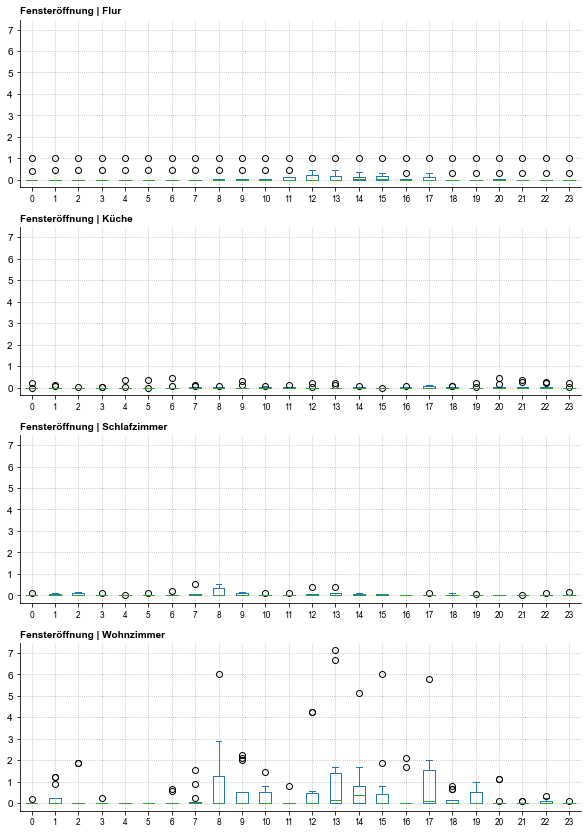

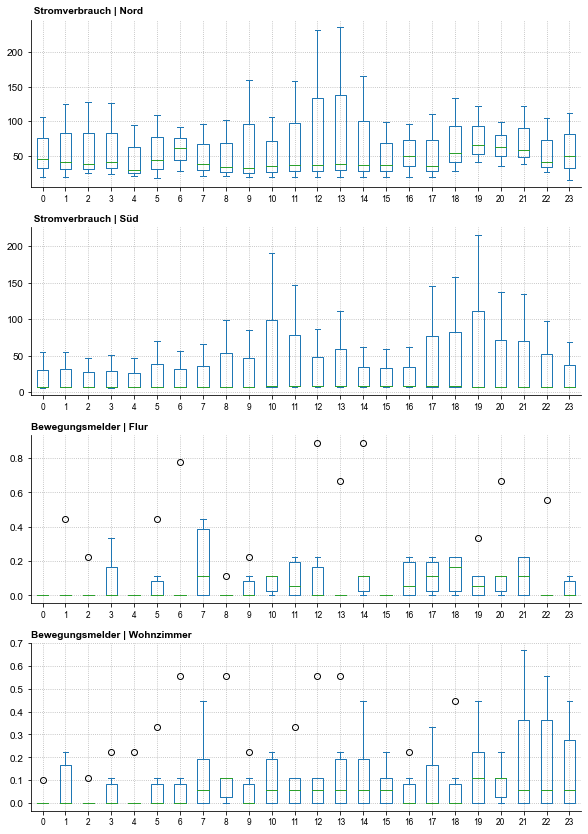

In [4]:
with PdfPages(os.path.join(path, 'Boxplots.pdf')) as pdf:
    df = pd.DataFrame(WINs).T.dropna(how='all').groupby(level=2)
    n = len(df.groups)
    fig, axs = plt.subplots(n,1, figsize = din_a4, sharey=True)
    for i, (name, group) in enumerate(df):
        ax = axs[i]
        group.plot.box(ax=ax)
        ax.set_title(f'Fensteröffnung | {ROOMS[name]}')
    fig.tight_layout()
    pdf.savefig(fig)

    df = pd.DataFrame(ELs).T.dropna(how='all').groupby(level=1)
    fig, axs = plt.subplots(4,1, figsize = din_a4)
    for i, (name, group) in enumerate(df):
        ax = axs[i]
        group.plot.box(ax=ax)
        ax.set_title(f' Stromverbrauch | {WOHNUNGEN[name]}')


    df = pd.DataFrame(MDs).T.dropna(how='all').groupby(level=2)
    for i, (name, group) in enumerate(df):
        ax = axs[2+i]
        group.plot.box(ax=ax)
        ax.set_title(f'Bewegungsmelder | {ROOMS[name]}')
    fig.tight_layout()
    pdf.savefig(fig)

## Auswertung Bewegungsmelder, Fensteröffnung, Stromverbrauch
____
gemittelt über alle Räume, Wohnungen und Häuser - stündliche Darstellung

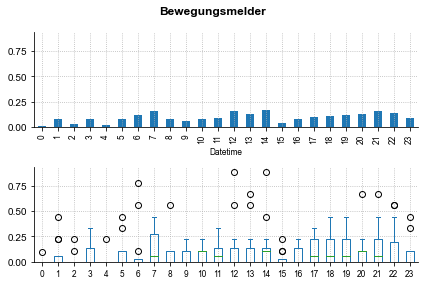

In [5]:
df = pd.DataFrame(MDs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Bewegungsmelder')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

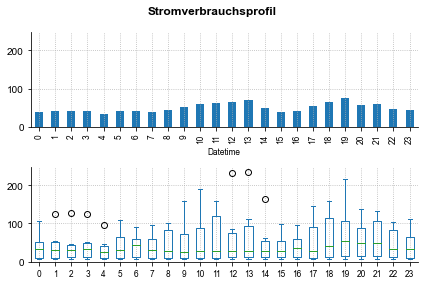

In [6]:
df = pd.DataFrame(ELs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Stromverbrauchsprofil')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

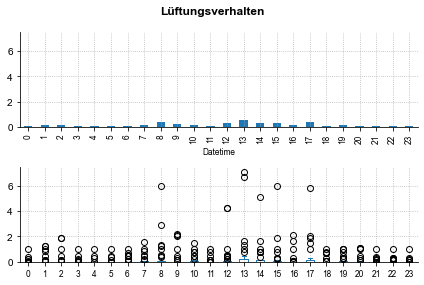

In [7]:
df = pd.DataFrame(WINs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Lüftungsverhalten')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

## Lüftung
___

MIT VORSICHT ZU GENIESSEN.

KEIN Plausibilitätscheck durchgeführt.

In [8]:
for bui in BUID:
    ind = IND[bui].loc['2021-06-01':]
    fig = plt.figure(figsize=din_a4_landscape,constrained_layout=True)
    gs = GridSpec(3, 4, figure=fig)
    axs=[]

    fig.suptitle('{}'.format(BUID[bui]),fontweight='bold')
    for i, app in enumerate(WOHNUNGEN):
        axs.append([])
        dfs = []

        for room in ROOMS:
            try:
                idx = []
                df = ind[app][room].filter(like='reed')                    
                """for window in df.columns.str.split(' ',expand=True).droplevel(level=1).unique():
                    if len(df.filter(like=window).columns) > 1:
                        df.iloc[:,1] = df.filter(like=window).iloc[:,1].fillna(df.filter(like=window).iloc[:,0])
                        df.drop(df.filter(like=window).iloc[:,0].name,axis=1,inplace=True)"""
                df.replace(['Closed','Open'],[0,1],inplace=True)
                for f,col in enumerate(df.columns):
                    t = col.split(' ')
                    ori = t[0].split('_')[0]
                    idx.append((room,'{}{}_{}'.format(ori,f, t[1])))
                df.columns = pd.MultiIndex.from_tuples(idx)
                dfs.append(df)
            except:
                continue

        df = pd.concat(dfs).resample('1min').max()

        n=len(df.columns)
        df1 = df.sum(axis=1)
        df1 = df1[df1 > 0]
        counts = df1.value_counts(normalize=True)
        gl = round(df1.dropna().mean(),1)
        ventkoeff = round(df.max(axis=1).value_counts(normalize=True)[1.0]*100,1)    #Anteil der Zeit in der Fenster geöffnet sind. Gewichtet nach Anzahl der Fenster.
        
        ### Histogramm
        j=0
        axs[i].append(fig.add_subplot(gs[i, 0]))
        df3 = df.sum(axis=1)
        df3.hist(ax = axs[i][j],bins=np.linspace(0,n+1,n+2), grid = False)
        axs[i][j].set_xticks(np.linspace(0,n,n+1)+0.5)
        axs[i][j].set_xticklabels(range(n+1))

        axs[i][j].set_ylabel('Zeit [h]')
        axs[i][j].set_title('Häufigkeitsverteilung ')
        ###Timeline
        j+=1
        axs[i].append(fig.add_subplot(gs[i, 1:]))
        axs[i][j].set_title('Wohnung {}'.format(WOHNUNGEN[app]),fontweight='bold')
        axs[i][j].text(
                0.0,
                0.95, 
                'Fenster pro Wohnung: {}\nZeit mit min. einem geöffnetem Fenster: {} %\nDurschnittlich gleichzeitig geöffnete Fenster: {}\nMaximal gleichzeitig geöffnete Fenster: {}'.format(n,ventkoeff,gl,int(df1.max())),      
                fontsize = 'large', 
                style='normal', 
                ha = 'left', 
                va = 'top',
                transform=axs[i][j].transAxes,
                bbox=eb_bbox, 
                )
        axs[i][j].set_ylim(0,24*60*n)
        axs[i][j].set_ylabel('Zeit\n' + r'$[n_{Fenster}*min_{geöffnet}]$')
        df2 = df.sum(axis=1).resample('D').sum()
        axs[i][j].bar(df2.index, df2)
        axs[i][j].plot(df2.rolling('30D').mean(),'r--')

    for ax in axs:
        ax[1].xaxis.set_major_locator(mdates.MonthLocator())
        ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if ex:
        export(fig,filepath=os.path.join(dir_results,'Lüftungsverhalten'),filename=f'{bui}_Übersicht', extlist=['pdf'])

C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Lüftungsverhalten\MH_Übersicht.pdf saved!
C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Lüftungsverhalten\MW_Übersicht.pdf saved!
C:\Users\Roman\workspace\eb-scripts\eb-data\Results\Lüftungsverhalten\LB_Übersicht.pdf saved!
